In [3]:
import pandas as pd
import numpy as np
import os
import string

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from matplotlib.lines import Line2D

from matplotlib.patches import Patch

import prim
import pandas as pd
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")



In [4]:
emissions = pd.read_excel('../../data/tidy/Emissions-Reduction-Calculation.xlsx')
activity = pd.read_csv('../../results/sectors/NewHaven-Emissions-Summary.csv')
activity

,Year,Sector,Subsector,Activity Data Description,Activity Data Unit,Activity Data,GHG Emissions (MMTCO2e),Population,Emissions per Capita (MTCO2e)
0,2021,Mobile Combustion,Automobile,Vehicle Miles Traveled,Billion Miles,2.806589,1.028899,864751,1.189821
1,2021,Mobile Combustion,Motorcycle,Vehicle Miles Traveled,Billion Miles,0.208674,0.036643,864751,0.042374
2,2021,Mobile Combustion,Trucks,Vehicle Miles Traveled,Billion Miles,3.870990,1.789613,864751,2.069512
3,2021,Mobile Combustion,Buses,Vehicle Miles Traveled,Billion Miles,0.025632,0.020234,864751,0.023399
4,2021,Electricity Consumption,Residential,Electricity Consumption,TWh,2.481066,0.612048,864751,0.707773
5,2021,Electricity Consumption,Commercial/Industrial,Electricity Consumption,TWh,2.849325,0.702893,864751,0.812827
6,2021,Solid Waste,Waste Combustion,Waste Combustion Emissions,,NaN,0.000000,864751,0.000000
7,2021,Solid Waste,Landfill Emissions,Landfills Emissions,,NaN,0.000000,864751,0.000000
8,2020,Stationary Combustion,Residential,Household Heating Oil Consumption,Million Gallon,74.623292,0.759970,855733,0.888093
9,2020,Stationary Combustion,Residential,Household Propane Consumption,Million Gallon,9.975587,0.057276,855733,0.066932


In [5]:
# Remove rows starting from index 20
emissions = emissions.iloc[:20]

# Keep only the first four columns
emissions = emissions.iloc[:17, :4]
emissions

,Sector,Subsector,Year,Total Emissions (MMTCO2e)
0,Mobile Combustion,Automobile,2021.0,1.028899
1,Mobile Combustion,Motorcycle,2021.0,0.036643
2,Mobile Combustion,Trucks,2021.0,1.789613
3,Mobile Combustion,Buses,2021.0,0.020234
4,Electricity Consumption,Residential Electricity,2021.0,0.612048
5,Electricity Consumption,Commercial&Industrial Electricity,2021.0,0.702893
6,Solid Waste Landfills,Landfill fuel combustion,2021.0,0.000000
7,Solid Waste Landfills,Landfill methane,2021.0,0.000000
8,Stationary Combustion,Residential fuel oil,2020.0,0.760000
9,Stationary Combustion,Residential natural gas,2020.0,0.540000


In [6]:
sum_emissions = emissions["Total Emissions (MMTCO2e)"].sum()

In [7]:
# EFmobile = [8.78, 10.21,0.008,0.007, 0,0,0.005,0.005,0.001,0.001] 
# EFe = [543.852]
# EFr = [10422.49,5741.65,54.44]
# R = [24.1, 22.1, 12.96, 50]

# EFcar = (8.78/24.1/1000+0.008*25/1000000+0.007*298/1000000)*1000000000
# EFmotor = 8.78/50/1000*1000000000
# EFtruck = (10.21/22.1/1000+0.001*25/1000000+0.001*298/1000000)*1000000000
# EFbus = (10.21/12.96/1000 + 0.005*25/1000000+0.005*298/1000000)*1000000000
# EFe = 543.852/2204.62
# Qrs = 1
# EFroil = 
# EFrgas = 
# EFrpropane = 


# EFGG = [EFcar,EFmotor,EFtruck,EFbus,EFe,Qrs,EFr,Qrc,Qri,Qra,Qrw]
#R represents a constant and it means mpg here: passenger_car gasoline, light truck diesel, heavy duty diesel, motorcycle gasoline
#gasoline, diesel, CH4 and N20 for gaso_passenger, gaso_motorcycle, bus, truck individually
Et = emissions['Total Emissions (MMTCO2e)'].tolist()
Qa = activity['Activity Data'].tolist()

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import qmc

# Example dataframe representing baseline values and upper/lower bounds
# data = {
#     'Label': ['u_1', 'u_2', 'u_3', 'u_4', 'u_5', 'u_6', 'u_7', 'u_8', 'u_9', 'u_10', 'u_11', 'u_12', 'u_13', 'u_14', 'u_15', 'u_16', 'u_17', 'u_18', 'u_19', 'u_20'],
#     'Parameter': ['Passenger car VMT', 'Motorcycle VMT', 'Trucks VMT', 'Bus VMT', 'Passenger car MPG', 'Motorcycle MPG', 'Trucks MPG', 'Bus MPG', 
#                   'Regional e-Grid emissions factors', 'Residential electricity consumption', 'Commercial and industrial electricity consumption', 
#                   'Residential fuel oil consumption', 'Residential propane consumption', 'Residential natural gas consumption', 'Commercial building footprint ratio', 
#                   'Industrial emissions', 'Organic fertilizer land area', 'Synthetic fertilizer land area', 'Manure fertilizer land area', 'Regional to state wastewater facility ratio'],
#     'Baseline Activity Value': [2.81, 0.21, 3.87, 0.03, 24.1, 50, 22.1, 12.96, 543.85, 2.48, 2.85, 74.62, 9.98, 9988.5, 0.25, 0.34, 173, 3764, 1125, 0.24],
#     'Lower Bound': [2.70, 0.1, 3.5, 0.02, 22, 48, 21, 12, 510, 2.3, 2.7, 72, 9, 9900, 0.2, 0.3, 170, 3700, 1100, 0.2],
#     'Upper Bound': [2.95, 0.3, 4.2, 0.05, 26, 52, 23, 13.5, 580, 2.7, 3.0, 77, 10, 10000, 0.3, 0.4, 180, 3800, 1150, 0.3]
# }

data = {
    'Label': ['u_1', 'u_2', 'u_3', 'u_4', 'u_5', 'u_6', 'u_7', 'u_8', 'u_9'],
    'Parameter': ['Car VMT', 'Truck VMT', 'Car MPG', 'E-grid EF', 'Res Elec Con', 'Com/Ind Elec Con', 'Res Fuel Oil', 'Res Propane', 'Res NG'],
    'Baseline Activity Value': [2.81, 3.87, 24.1, 543.85, 2.48, 2.85, 74.62, 9.98, 9988.5],
    'Lower Bound': [2.81 * (1 - 1), 3.87 * (1 - 1), 24.1 * (1 - 0.5), 543.85 * (1 - 1), 2.48 * (1 - 0.80), 
                    2.85 * (1 - 0.80), 74.62 * (1 - 1), 9.98 * (1 - 1), 9988.5 * (1 - 1)],
    'Upper Bound': [2.81 * (1 + 1), 3.87 * (1 + 1), 24.1 * (1 + 1), 543.85 * (1 + 1), 2.48 * (1 + 1), 
                    2.85 * (1 + 1), 74.62 * (1 + 1), 9.98 * (1 + 1), 9988.5 * (1 + 1)]
}



# Create the dataframe
activity_df = pd.DataFrame(data)

# Number of samples you want to generate
num_samples = 10000  # You can adjust this

# Initialize the Latin Hypercube Sampling generator (20 dimensions, one for each parameter)
sampler = qmc.LatinHypercube(d=20, seed=42)  # 20 dimensions (parameters)
lhs_samples = sampler.random(n=num_samples)  # Generate random samples

# Rescale the samples to match the bounds in the activity_df
scaled_samples = np.zeros_like(lhs_samples)
for i, param in enumerate(activity_df['Parameter']):
    low = activity_df.loc[i, 'Lower Bound']
    high = activity_df.loc[i, 'Upper Bound']
    
    # Check if bounds are valid and consistent (no NaN and l_bounds < u_bounds)
    if np.isnan(low) or np.isnan(high) or low >= high:
        print(f"Invalid bounds for parameter '{param}': Lower Bound = {low}, Upper Bound = {high}")
        continue  # Skip this parameter if bounds are invalid
    
    # Reshape lhs_samples[:, i] to a 2D array and then scale it to the parameter bounds
    scaled_samples[:, i] = qmc.scale(lhs_samples[:, i].reshape(-1, 1), l_bounds=[low], u_bounds=[high]).flatten()

# Calculate continuous uncertainty over the samples
uncertainty_ranges_continuous = []
for i, param in enumerate(activity_df['Parameter']):
    baseline = activity_df.loc[i, 'Baseline Activity Value']
    
    # Calculate the uncertainty across all the scaled samples for this parameter
    uncertainty_range = scaled_samples[:, i] 
    
    # Store the uncertainty for visualization or analysis
    uncertainty_ranges_continuous.append({
        'Parameter': param,
        'Uncertainty Distribution': uncertainty_range
    })

# Convert the uncertainty range list to a DataFrame for better presentation
uncertainty_df_continuous = pd.DataFrame(uncertainty_ranges_continuous)


# Optional: Plotting the distribution of the uncertainty for the first parameter
# plt.hist(uncertainty_ranges_continuous[0]['Uncertainty Distribution'], bins=30, alpha=0.7, label=activity_df['Parameter'][0])
# plt.xlabel("Uncertainty Value")
# plt.ylabel("Frequency")
# plt.legend()
# plt.show()
uncertainty_df_continuous
uncertainty_df_continuous.to_excel("uncertainty_summary_statistics.xlsx", index=False)
uncertainty_df_continuous

,Parameter,Uncertainty Distribution
0,Car VMT,"[4.892899036700713, 5.237975954690072, 4.75371..."
1,Truck VMT,"[0.8456423080876321, 4.6715895969006676, 2.048..."
2,Car MPG,"[42.282756168519526, 40.69175092664182, 46.874..."
3,E-grid EF,"[648.7371972794792, 836.3441552156338, 305.609..."
4,Res Elec Con,"[4.016268359231903, 4.834660529606906, 1.74376..."
5,Com/Ind Elec Con,"[4.8576665057336115, 4.562579150342872, 3.1951..."
6,Res Fuel Oil,"[93.33826075108752, 39.18345865574038, 106.372..."
7,Res Propane,"[4.291827015646668, 17.41102056768349, 4.04531..."
8,Res NG,"[11943.992367396006, 355.2823758816967, 14657...."


In [9]:
# Merge the two dataframes on the 'Parameter' column
df = pd.merge(uncertainty_df_continuous, activity_df, on='Parameter')

# Function to calculate percentage change for each value in the Uncertainty Distribution
def calculate_percentage_change(row):
    baseline_value = row['Baseline Activity Value']
    return [(x - baseline_value) / baseline_value * 100 for x in row['Uncertainty Distribution']]

# Apply the function to each row and create new columns for the percentage change
df['Uncertainty % Change'] = df.apply(calculate_percentage_change, axis=1)

# Display the updated dataframe
df[['Parameter', 'Uncertainty Distribution', 'Uncertainty % Change']]

,Parameter,Uncertainty Distribution,Uncertainty % Change
0,Car VMT,"[4.892899036700713, 5.237975954690072, 4.75371...","[74.1245208790289, 86.4048382451983, 69.171256..."
1,Truck VMT,"[0.8456423080876321, 4.6715895969006676, 2.048...","[-78.14877756879504, 20.7129094806374, -47.056..."
2,Car MPG,"[42.282756168519526, 40.69175092664182, 46.874...","[75.44712103120135, 68.84543952963408, 94.4994..."
3,E-grid EF,"[648.7371972794792, 836.3441552156338, 305.609...","[19.28605263941881, 53.78213757757355, -43.806..."
4,Res Elec Con,"[4.016268359231903, 4.834660529606906, 1.74376...","[61.94630480773803, 94.94598909705267, -29.686..."
5,Com/Ind Elec Con,"[4.8576665057336115, 4.562579150342872, 3.1951...","[70.44443879767057, 60.09049650325866, 12.1095..."
6,Res Fuel Oil,"[93.33826075108752, 39.18345865574038, 106.372...","[25.08477720596021, -47.48933442007454, 42.552..."
7,Res Propane,"[4.291827015646668, 17.41102056768349, 4.04531...","[-56.995721286105535, 74.45912392468426, -59.4..."
8,Res NG,"[11943.992367396006, 355.2823758816967, 14657....","[19.577437727346506, -96.44308578984136, 46.74..."


In [10]:
uncertainty_df_continuous=df
uncertainty_df_continuous = uncertainty_df_continuous.drop(['Label','Baseline Activity Value','Lower Bound','Upper Bound'], axis=1)
uncertainty_df_continuous

,Parameter,Uncertainty Distribution,Uncertainty % Change
0,Car VMT,"[4.892899036700713, 5.237975954690072, 4.75371...","[74.1245208790289, 86.4048382451983, 69.171256..."
1,Truck VMT,"[0.8456423080876321, 4.6715895969006676, 2.048...","[-78.14877756879504, 20.7129094806374, -47.056..."
2,Car MPG,"[42.282756168519526, 40.69175092664182, 46.874...","[75.44712103120135, 68.84543952963408, 94.4994..."
3,E-grid EF,"[648.7371972794792, 836.3441552156338, 305.609...","[19.28605263941881, 53.78213757757355, -43.806..."
4,Res Elec Con,"[4.016268359231903, 4.834660529606906, 1.74376...","[61.94630480773803, 94.94598909705267, -29.686..."
5,Com/Ind Elec Con,"[4.8576665057336115, 4.562579150342872, 3.1951...","[70.44443879767057, 60.09049650325866, 12.1095..."
6,Res Fuel Oil,"[93.33826075108752, 39.18345865574038, 106.372...","[25.08477720596021, -47.48933442007454, 42.552..."
7,Res Propane,"[4.291827015646668, 17.41102056768349, 4.04531...","[-56.995721286105535, 74.45912392468426, -59.4..."
8,Res NG,"[11943.992367396006, 355.2823758816967, 14657....","[19.577437727346506, -96.44308578984136, 46.74..."


In [11]:
EFmco2_gasoline = 8.78 
EFmco2_diesel = 10.21
EFmch4_car = 0.008
EFmn2o_car =0.007
EFmch4_motorcycle = 0
EFmn2o_motorcycle = 0 
EFmch4_buses = 0.005
EFmn2o_buses = 0.005
EFmch4_trucks = 0.001
EFmn2o_trucks = 0.001 
EFer_oil = 10150+ 0.41*25+0.08*298
EFer_propane = 5720+0.27*25+0.05*298
EFer_naturalgas = 54.44


In [12]:
# Step 1: Explode the list into rows while keeping the order
df_expanded = uncertainty_df_continuous.explode("Uncertainty % Change", ignore_index=False)

# Step 2: Create a proper index based on original order
df_expanded["Row_Index"] = df_expanded.groupby(df_expanded.index).cumcount()

# Step 3: Pivot without changing the order of parameters
df_final = df_expanded.pivot(index="Row_Index", columns="Parameter", values="Uncertainty % Change")

# Step 4: Preserve the original parameter order by reordering columns using df.index
df_final = df_final.loc[:, uncertainty_df_continuous["Parameter"]]

# Step 5: Reset column names
df_final.columns.name = None  

df_final

,Car VMT,Truck VMT,Car MPG,E-grid EF,Res Elec Con,Com/Ind Elec Con,Res Fuel Oil,Res Propane,Res NG
Row_Index,,,,,,,,,
0,74.124521,-78.148778,75.447121,19.286053,61.946305,70.444439,25.084777,-56.995721,19.577438
1,86.404838,20.712909,68.84544,53.782138,94.945989,60.090497,-47.489334,74.459124,-96.443086
2,69.171257,-47.056654,94.499496,-43.806247,-29.686981,12.109514,42.55225,-59.465767,46.74635
3,-48.833368,83.190578,-5.788479,73.7847,85.606575,-41.723964,88.348816,17.273921,-86.460616
4,-2.573286,-69.168128,85.25779,89.076661,-56.438409,-20.835621,64.905553,64.410762,-47.783225
...,...,...,...,...,...,...,...,...,...
9995,16.451719,74.182093,10.419156,68.74762,21.138181,-66.059147,51.048148,35.541866,99.119741
9996,35.642284,-85.071942,-1.557782,94.363354,1.212095,-66.438124,67.575315,32.409753,30.556404
9997,28.68721,29.364681,47.926585,78.062769,31.835159,62.114478,62.769423,91.332272,84.395684


In [13]:
VMT_car = uncertainty_df_continuous['Uncertainty Distribution'][0]
VMT_trucks  = uncertainty_df_continuous['Uncertainty Distribution'][1]

mpg_car = uncertainty_df_continuous['Uncertainty Distribution'][2]

EFee = uncertainty_df_continuous['Uncertainty Distribution'][3]
Qre = uncertainty_df_continuous['Uncertainty Distribution'][4]
Qce = uncertainty_df_continuous['Uncertainty Distribution'][5]

Qrfuel = uncertainty_df_continuous['Uncertainty Distribution'][6]
Qrpropane = uncertainty_df_continuous['Uncertainty Distribution'][7]
Qrgas = uncertainty_df_continuous['Uncertainty Distribution'][8]

In [14]:
Eim_car = emissions['Total Emissions (MMTCO2e)'][0]
Eim_motorcycle = emissions['Total Emissions (MMTCO2e)'][1]
Eim_trucks = emissions['Total Emissions (MMTCO2e)'][2]
Eim_buses = emissions['Total Emissions (MMTCO2e)'][3]
Ei_r_e = emissions['Total Emissions (MMTCO2e)'][4]
Ei_c_e = emissions['Total Emissions (MMTCO2e)'][5]

Ei_r_oil = emissions['Total Emissions (MMTCO2e)'][8]
Eim_r_gas = emissions['Total Emissions (MMTCO2e)'][9]
Eim_r_propane = emissions['Total Emissions (MMTCO2e)'][10]
Eim_commr = emissions['Total Emissions (MMTCO2e)'][11]
Eim_indus = emissions['Total Emissions (MMTCO2e)'][12]
Eim_organic = emissions['Total Emissions (MMTCO2e)'][13]
Eim_synthetic = emissions['Total Emissions (MMTCO2e)'][14]
Eim_manure = emissions['Total Emissions (MMTCO2e)'][15]
Eim_waste = emissions['Total Emissions (MMTCO2e)'][16]


In [15]:
#mobile combustion
def model_emissions_Em(VMT,mpg,EFmco2,EFmch4,EFmn2o):
    Em = (VMT*1000000*EFmco2/mpg+VMT*EFmch4*1000*25+VMT*EFmn2o*1000*25)/1000000
    return Em

#electricity consumption, residential consumption
def model_emissions_Eer(Qe,EFe):
    Ee = Qe*EFe/2204.62
    return Ee

# residential consumption
def model_emissions_Er(Qe,EFe):
    Ee = Qe*EFe/1000000
    return Ee

Erest = Eim_commr+Eim_indus+Eim_organic+Eim_synthetic+Eim_manure+Eim_waste

In [16]:
#mobile emissions
Emissions_mobile_car_vmt = model_emissions_Em(VMT_car, mpg_car, EFmco2_gasoline, EFmch4_car,EFmn2o_car)
Emissions_mobile_trucks_vmt = model_emissions_Em(VMT_trucks, 22.1, EFmco2_diesel,EFmch4_trucks,EFmn2o_trucks)
Emissions_mobile_buses_motorcycle = Eim_motorcycle+Eim_buses

#electricity consumption emissions
Emissions_electricity_residential= model_emissions_Eer(Qre,EFee)
Emissions_electricity_commercial_industrial = model_emissions_Eer(Qce,EFee)

# Emissions_electricity_residential_Q= model_emissions_Eer(Ei_r_e,Qre,543.852)
# Emissions_electricity_commercial_industrial_Q = model_emissions_Eer(Ei_c_e,Qce,543.852)

#stationary combustion emissions
Emissions_residential_oil= model_emissions_Er(Qrfuel,EFer_oil)
Emissions_residential_propane = model_emissions_Er(Qrpropane,EFer_propane)
Emissions_residential_gas= model_emissions_Er(Qrgas,EFer_naturalgas)

Etotal = Emissions_mobile_car_vmt+Emissions_mobile_trucks_vmt+Emissions_mobile_buses_motorcycle+Emissions_electricity_residential+Emissions_electricity_commercial_industrial+Emissions_residential_oil+Emissions_residential_propane+Emissions_residential_gas+Erest

#Etotal
Etotal

# Compute final values
Epercent = (sum_emissions - Etotal) / sum_emissions * 100


In [17]:
#sensitivity analysis

Emissions_mobile_car_vmt_sen = sum_emissions+model_emissions_Em(VMT_car, 24.1, EFmco2_gasoline, EFmch4_car,EFmn2o_car)-Eim_car
Emissions_mobile_car_mpg_sen = sum_emissions+model_emissions_Em(2.81, mpg_car, EFmco2_gasoline, EFmch4_car,EFmn2o_car)-Eim_car
Emissions_mobile_trucks_vmt_sen = model_emissions_Em(VMT_trucks, 22.1, EFmco2_diesel,EFmch4_trucks,EFmn2o_trucks)+sum_emissions-Eim_trucks

Emissions_electricity_residential_sen = model_emissions_Eer(Qre,543.85)+sum_emissions-Ei_r_e
Emissions_electricity_residential_sen_ef = model_emissions_Eer(2.48,EFee)+sum_emissions-Ei_r_e
Emissions_electricity_commercial_industrial_sen = model_emissions_Eer(Qce,543.85)+sum_emissions-Ei_c_e
Emissions_electricity_commercial_industrial_sen_ef = model_emissions_Eer(2.85,EFee)+sum_emissions-Ei_c_e

Emissions_residential_oil_sen= model_emissions_Er(Qrfuel,EFer_oil)+sum_emissions-Ei_r_oil
Emissions_residential_propane_sen = model_emissions_Er(Qrpropane,EFer_propane)+sum_emissions-Eim_r_propane
Emissions_residential_gas_sen= model_emissions_Er(Qrgas,EFer_naturalgas)+sum_emissions-Eim_r_gas

In [18]:
# Calculate emission reductions for each scenario
emission_reduction_car_vmt = ((sum_emissions - Emissions_mobile_car_vmt_sen) / sum_emissions) * 100
emission_reduction_car_mpg = ((sum_emissions - Emissions_mobile_car_mpg_sen) / sum_emissions) * 100
emission_reduction_trucks_vmt = ((sum_emissions - Emissions_mobile_trucks_vmt_sen) / sum_emissions) * 100

emission_reduction_residential_elec = ((sum_emissions - Emissions_electricity_residential_sen) / sum_emissions) * 100
emission_reduction_residential_elec_ef = ((sum_emissions - Emissions_electricity_residential_sen_ef) / sum_emissions) * 100
emission_reduction_commercial_elec = ((sum_emissions - Emissions_electricity_commercial_industrial_sen) / sum_emissions) * 100
emission_reduction_commercial_elec_ef = ((sum_emissions - Emissions_electricity_commercial_industrial_sen_ef) / sum_emissions) * 100

emission_reduction_residential_oil = ((sum_emissions - Emissions_residential_oil_sen) / sum_emissions) * 100
emission_reduction_residential_propane = ((sum_emissions - Emissions_residential_propane_sen) / sum_emissions) * 100
emission_reduction_residential_gas = ((sum_emissions - Emissions_residential_gas_sen) / sum_emissions) * 100


In [19]:
# Create DataFrame
data = {
    'Label': ['u_1', 'u_2', 'u_3', 'u_4', 'u_5', 'u_6', 'u_7', 'u_8', 'u_9'],
    'Parameter': ['Car VMT', 'Truck VMT', 'Car MPG', 'E-grid EF', 'Res Elec Con', 'Com/Ind Elec Con', 'Res Fuel Oil', 'Res Propane', 'Res NG'],
    'Baseline Activity Value': [2.81, 3.87, 24.1, 543.85, 2.48, 2.85, 74.62, 9.98, 9988.5]
}
df = pd.DataFrame(data)


# Compute lower and upper bounds (±10%)
df['Lower Bound'] = df['Baseline Activity Value'] * 0.9
df['Upper Bound'] = df['Baseline Activity Value'] * 1.1

# Function to calculate emissions reductions
def calculate_emission_reduction(row):
    param = row['Parameter']
    baseline = row['Baseline Activity Value']
    lower = row['Lower Bound']
    upper = row['Upper Bound']
    
    if param == 'Car VMT':
        emissions_baseline = model_emissions_Em(baseline, 24.1, EFmco2_gasoline, EFmch4_car, EFmn2o_car) + sum_emissions - Eim_car
        emissions_lower = model_emissions_Em(lower, 24.1, EFmco2_gasoline, EFmch4_car, EFmn2o_car) + sum_emissions - Eim_car
        emissions_upper = model_emissions_Em(upper, 24.1, EFmco2_gasoline, EFmch4_car, EFmn2o_car) + sum_emissions - Eim_car
    elif param == 'Truck VMT':
        emissions_baseline = model_emissions_Em(baseline, 22.1, EFmco2_diesel, EFmch4_trucks, EFmn2o_trucks) + sum_emissions - Eim_trucks
        emissions_lower = model_emissions_Em(lower, 22.1, EFmco2_diesel, EFmch4_trucks, EFmn2o_trucks) + sum_emissions - Eim_trucks
        emissions_upper = model_emissions_Em(upper, 22.1, EFmco2_diesel, EFmch4_trucks, EFmn2o_trucks) + sum_emissions - Eim_trucks
    elif param == 'Car MPG':
        emissions_baseline = model_emissions_Em(2.81, baseline, EFmco2_diesel, EFmch4_trucks, EFmn2o_trucks) + sum_emissions - Eim_trucks
        emissions_lower = model_emissions_Em(2.81, lower, EFmco2_diesel, EFmch4_trucks, EFmn2o_trucks) + sum_emissions - Eim_trucks
        emissions_upper = model_emissions_Em(2.81, upper, EFmco2_diesel, EFmch4_trucks, EFmn2o_trucks) + sum_emissions - Eim_trucks
    elif param == 'E-grid EF':
        emissions_baseline = model_emissions_Eer(2.48, baseline) + sum_emissions - Ei_r_e
        emissions_lower = model_emissions_Eer(2.48, lower) + sum_emissions - Ei_r_e
        emissions_upper = model_emissions_Eer(2.48, upper) + sum_emissions - Ei_r_e
    elif param == 'Res Elec Con':
        emissions_baseline = model_emissions_Eer(baseline, 543.85) + sum_emissions - Ei_r_e
        emissions_lower = model_emissions_Eer(lower, 543.85) + sum_emissions - Ei_r_e
        emissions_upper = model_emissions_Eer(upper, 543.85) + sum_emissions - Ei_r_e
    elif param == 'Com/Ind Elec Con':
        emissions_baseline = model_emissions_Eer(baseline, 543.85) + sum_emissions - Ei_c_e
        emissions_lower = model_emissions_Eer(lower, 543.85) + sum_emissions - Ei_c_e
        emissions_upper = model_emissions_Eer(upper, 543.85) + sum_emissions - Ei_c_e
    elif param == 'Res Fuel Oil':
        emissions_baseline = model_emissions_Er(baseline, EFer_oil) + sum_emissions - Ei_r_oil
        emissions_lower = model_emissions_Er(lower, EFer_oil) + sum_emissions - Ei_r_oil
        emissions_upper = model_emissions_Er(upper, EFer_oil) + sum_emissions - Ei_r_oil
    elif param == 'Res Propane':
        emissions_baseline = model_emissions_Er(baseline, EFer_propane) + sum_emissions - Eim_r_propane
        emissions_lower = model_emissions_Er(lower, EFer_propane) + sum_emissions - Eim_r_propane
        emissions_upper = model_emissions_Er(upper, EFer_propane) + sum_emissions - Eim_r_propane
    elif param == 'Res NG':
        emissions_baseline = model_emissions_Er(baseline, EFer_naturalgas) + sum_emissions - Eim_r_gas
        emissions_lower = model_emissions_Er(lower, EFer_naturalgas) + sum_emissions - Eim_r_gas
        emissions_upper = model_emissions_Er(upper, EFer_naturalgas) + sum_emissions - Eim_r_gas
    else:
        return pd.Series([None, None])
    
    reduction_lower = ((sum_emissions - emissions_lower) / sum_emissions) * 100
    reduction_upper = ((sum_emissions - emissions_upper) / sum_emissions) * 100
    
    return pd.Series([reduction_lower, reduction_upper])

# Apply calculations
df[['Reduction_Lower (%)', 'Reduction_Upper (%)']] = df.apply(calculate_emission_reduction, axis=1)
df

,Label,Parameter,Baseline Activity Value,Lower Bound,Upper Bound,Reduction_Lower (%),Reduction_Upper (%)
0,u_1,Car VMT,2.81,2.529,3.091,1.528973,-1.410800
1,u_2,Truck VMT,3.87,3.483,4.257,2.586466,-2.543030
2,u_3,Car MPG,24.10,21.690,26.510,6.694629,10.144183
3,u_4,E-grid EF,543.85,489.465,598.235,0.881311,-0.873702
4,u_5,Res Elec Con,2.48,2.232,2.728,0.881311,-0.873702
5,u_6,Com/Ind Elec Con,2.85,2.565,3.135,1.006073,-1.010776
6,u_7,Res Fuel Oil,74.62,67.158,82.082,1.090917,-1.089104
7,u_8,Res Propane,9.98,8.982,10.978,0.120894,-0.043487
8,u_9,Res NG,9988.50,8989.650,10987.350,0.725827,-0.834090


In [20]:
# Sort the DataFrame by emission reduction in descending order
df = df.sort_values(by="Reduction_Lower (%)", ascending=False)
df

,Label,Parameter,Baseline Activity Value,Lower Bound,Upper Bound,Reduction_Lower (%),Reduction_Upper (%)
2,u_3,Car MPG,24.10,21.690,26.510,6.694629,10.144183
1,u_2,Truck VMT,3.87,3.483,4.257,2.586466,-2.543030
0,u_1,Car VMT,2.81,2.529,3.091,1.528973,-1.410800
6,u_7,Res Fuel Oil,74.62,67.158,82.082,1.090917,-1.089104
5,u_6,Com/Ind Elec Con,2.85,2.565,3.135,1.006073,-1.010776
3,u_4,E-grid EF,543.85,489.465,598.235,0.881311,-0.873702
4,u_5,Res Elec Con,2.48,2.232,2.728,0.881311,-0.873702
8,u_9,Res NG,9988.50,8989.650,10987.350,0.725827,-0.834090
7,u_8,Res Propane,9.98,8.982,10.978,0.120894,-0.043487


In [21]:
# Data to be visualized
value_5 = df['Reduction_Lower (%)']
value_95 = df['Reduction_Upper (%)']
base = 0

# plot parameters
yTick_label = df['Parameter']
ys = range(len(yTick_label))[::-1]
height = 0.8

# Figure setup
plt.figure(figsize=(6.5,8))
color_5 = '#0d47a1'
color_95 = '#e2711d'
color_line = '#2ECC71'

<Figure size 650x800 with 0 Axes>

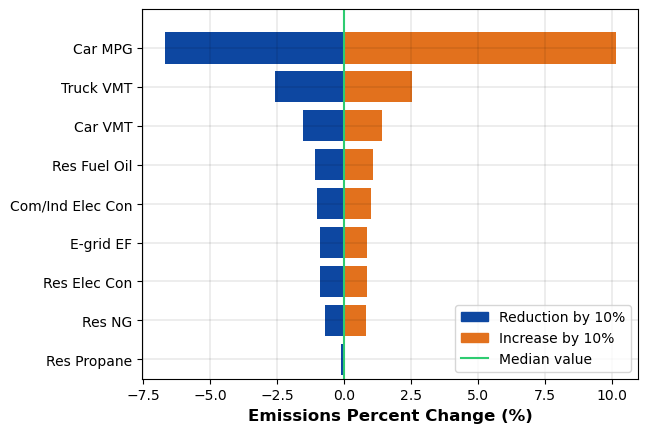

In [22]:
# Draw bars for 5%
for y, value in zip(ys, value_5):
    plt.broken_barh([(base, -np.abs(base-value))], (y - height/2,height), facecolors=[color_5,color_5])

# Draw bars for 95%
for y, value2 in zip(ys, value_95):
    plt.broken_barh([(base, np.abs(base-value2))], (y - height/2, height),facecolors=[color_95,color_95])

# Add vertical line for median value
plt.axvline(base, color=color_line, linewidth=1.5, label='Median value')  

# Modify the graph
plt.ylim([-0.5, 9])
plt.yticks(ys, yTick_label)
plt.grid(linewidth=0.1, color='black')
plt.xlabel('Emissions Percent Change (%)', fontsize=12, fontweight='bold')

# Add legend
handles = [Patch(color=color_5, label='Reduction by 10%'), Patch(color=color_95, label='Increase by 10%'),
           Line2D([0], [0], color=color_line, linewidth=1.5, label='Median value')]
plt.legend(handles=handles, loc='lower right')
plt.show()

(array([  2.,   3.,   2.,   2.,   1.,   4.,   7.,  15.,  13.,  19.,  16.,
         26.,  31.,  29.,  36.,  56.,  67.,  92.,  82.,  75.,  95., 122.,
        124., 102., 167., 155., 160., 177., 185., 240., 195., 214., 241.,
        221., 265., 243., 244., 275., 255., 239., 275., 267., 284., 257.,
        270., 255., 233., 243., 232., 204., 222., 212., 203., 193., 186.,
        177., 153., 145., 126., 138., 112., 107., 113., 103.,  91.,  73.,
         75.,  71.,  66.,  49.,  49.,  37.,  42.,  34.,  26.,  30.,  27.,
         15.,  20.,  15.,  10.,  12.,  10.,   5.,   6.,   6.,   6.,   4.,
          1.,   3.,   6.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 2.13858907,  2.25368952,  2.36878996,  2.48389041,  2.59899086,
         2.71409131,  2.82919175,  2.9442922 ,  3.05939265,  3.17449309,
         3.28959354,  3.40469399,  3.51979444,  3.63489488,  3.74999533,
         3.86509578,  3.98019623,  4.09529667,  4.21039712,  4.32549757,
         4.44059802,  4.55

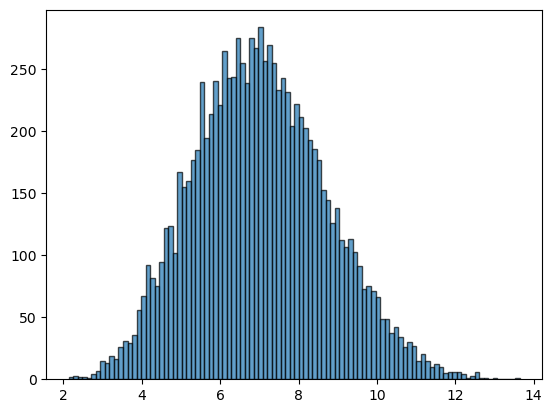

In [23]:
plt.hist(Etotal, bins=100, edgecolor='black', alpha=0.7)

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,   6.,   3.,
          1.,   4.,   6.,   6.,   6.,   5.,  10.,  12.,  10.,  15.,  20.,
         15.,  27.,  30.,  26.,  34.,  42.,  37.,  49.,  49.,  66.,  71.,
         75.,  73.,  91., 103., 113., 107., 112., 138., 126., 145., 153.,
        177., 186., 193., 203., 212., 222., 204., 232., 243., 233., 255.,
        270., 257., 284., 267., 275., 239., 255., 275., 244., 243., 265.,
        221., 241., 214., 195., 240., 185., 177., 160., 155., 167., 102.,
        124., 122.,  95.,  75.,  82.,  92.,  67.,  56.,  36.,  29.,  31.,
         26.,  16.,  19.,  13.,  15.,   7.,   4.,   1.,   2.,   2.,   3.,
          2.]),
 array([-9.57683125e+01, -9.41173765e+01, -9.24664406e+01, -9.08155046e+01,
        -8.91645687e+01, -8.75136327e+01, -8.58626967e+01, -8.42117608e+01,
        -8.25608248e+01, -8.09098889e+01, -7.92589529e+01, -7.76080169e+01,
        -7.59570810e+01, -7.43061450e+01, -7.26552091e+01, -7.10042731e+01,
        -6.935

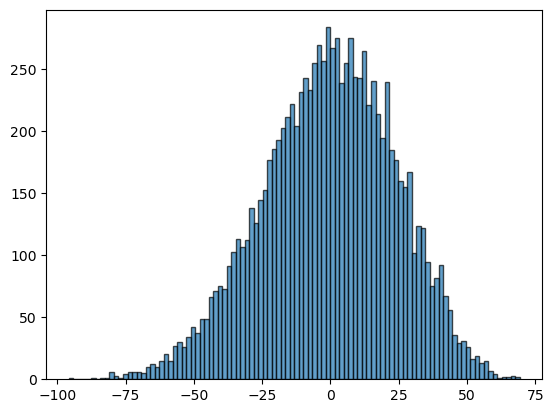

In [24]:
plt.hist(Epercent, bins=100, edgecolor='black', alpha=0.7)

#emissions reduction versus variables
#lolipoop: how much emisisons reduction/change by the change of each parameter (by lolipop/tornado plot)---go to prim

In [25]:
df_final['Emissions (MMTCO2e)'] = Etotal
df_final['Emissions Percent Change (%)'] = Epercent

In [26]:
df_final

,Car VMT,Truck VMT,Car MPG,E-grid EF,Res Elec Con,Com/Ind Elec Con,Res Fuel Oil,Res Propane,Res NG,Emissions (MMTCO2e),Emissions Percent Change (%)
Row_Index,,,,,,,,,,,
0,74.124521,-78.148778,75.447121,19.286053,61.946305,70.444439,25.084777,-56.995721,19.577438,7.123648,-2.177595
1,86.404838,20.712909,68.84544,53.782138,94.945989,60.090497,-47.489334,74.459124,-96.443086,8.852290,-26.972263
2,69.171257,-47.056654,94.499496,-43.806247,-29.686981,12.109514,42.55225,-59.465767,46.74635,5.906395,15.281992
3,-48.833368,83.190578,-5.788479,73.7847,85.606575,-41.723964,88.348816,17.273921,-86.460616,9.568049,-37.238708
4,-2.573286,-69.168128,85.25779,89.076661,-56.438409,-20.835621,64.905553,64.410762,-47.783225,5.756651,17.429835
...,...,...,...,...,...,...,...,...,...,...,...
9995,16.451719,74.182093,10.419156,68.74762,21.138181,-66.059147,51.048148,35.541866,99.119741,9.635371,-38.204331
9996,35.642284,-85.071942,-1.557782,94.363354,1.212095,-66.438124,67.575315,32.409753,30.556404,6.878697,1.335841
9997,28.68721,29.364681,47.926585,78.062769,31.835159,62.114478,62.769423,91.332272,84.395684,10.498396,-50.583074


In [27]:
df = df_final[df_final.columns[:9]]
response = df_final['Emissions Percent Change (%)']

p = prim.Prim(df, response, threshold=-50, threshold_type="<")

In [ ]:
box = p.find_box()

In [ ]:
box.show_tradeoff()

In [ ]:
plt.show()